# Lab 3: Learning in CNNs

### Neural Networks and Deep Learning PhD course 2019
 

## Convolution

Convolution is a way to compute the response of a kernel that is applied to a feature map, or more in general, to a signal. In order to understand the algorithmic aspects and conceptual pitfalls of convolution, we will first look into simple one-dimensional examples.  
Linear convolution of a discrete kernel $h$ and a signal $f$ is defined by the infinite sum
$$ g(x) = (h*f)(x) = \sum_{\lambda=-\infty}^\infty h(x-\lambda)f(\lambda)\enspace.$$
When $h$ and $f$ are of finite length, there are several options. To understand these, we will look at those for the case of the example  
$$ f = \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$$  

$$ h = \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$$  

The different options originate from different interpretations of the unknown values outside the range of $f$ and $h$:
*  ´'full'´: all unknown values are assumed as zero. The convolution is computed for all non-zero coefficients of $g$.
*  ´'valid'´: all unknown values of $f$ are assumed as undefined. The convolution is computed for all shifts of $h$ such that the support of $h$ lies entirely within the support of $f$.
*  ´'same'´: same as ´'full'´, but the result $g$ is restricted to of the same size as $f$. The origin (bold) is supposed not to move.  

---

In [2]:
#!pip install tensorflow-gpu 
import tensorflow as tf
print(tf.__version__)


2.1.0


In [3]:
#!pip install tensorflow-gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0


In [4]:
import os
import warnings
# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
#import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


**Task 1:** Try different options `'full'`/`'valid'`/`'same'` by using the function `scipy.signal.convolve` for the example above.

In [8]:
import numpy as np
from scipy import signal
f = [1,-1,-2,0,-1,1,2,-1]
h = [1,2,-2]
con_full =  signal.convolve(f,h, mode = 'full')
print('full = ', con_full)
con_same =  signal.convolve(f,h, mode = 'same')
print('same = ', con_same)
con_valid =  signal.convolve(f,h, mode = 'valid')
print('valid = ', con_valid)


full =  [ 1  1 -6 -2  3 -1  6  1 -6  2]
same =  [ 1 -6 -2  3 -1  6  1 -6]
valid =  [-6 -2  3 -1  6  1]


**Task 2:** If $N$ is the number of coefficients in $f$ and $M$ is the number of coefficients in $h$, what is the number of coefficients in $g$ in the case `'full'`/`'valid'`/`'same'`?

---

Full = N+M-1

Same = Max(M,N)

Valid = Max(M,N) - Min(M,N) +1



## Image examples (2D)
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [0]:
from matplotlib import pyplot as plt

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

---

**Task 3:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      1 & 1 \\
      \hline
      1 & 1 \\
      \hline
    \end{array}$. Visualize the kernel.

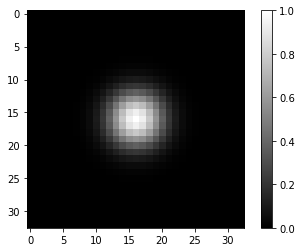

Image size: (33, 33)


In [10]:
from scipy import signal

# Normalize the Filter 
h = np.array([[1,1],[1,1]])
for i  in range(0,5):
     h = signal.convolve2d(h,h)

h = h/h.max()        
visualize(h)

**Task 4:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), sum its RGB-channels, normalized it to the range [0,1], and convolve it with $h$ from task 3 under the options `'valid'` and `'same'`. What differences do you observe regarding the size of the output?

---

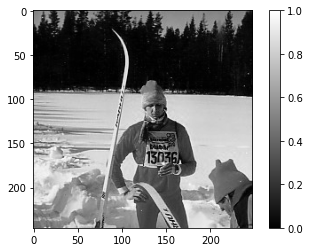

Image size: (246, 248)

Valid Case


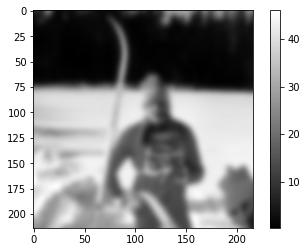

Image size: (214, 216)

Same Case


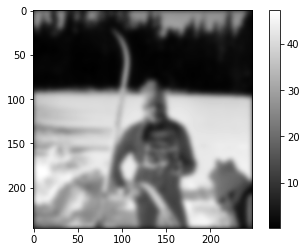

Image size: (246, 248)


In [18]:
from matplotlib.image import imread

img = imread('MR15^044.JPG')
#visualize(img)

# Sum and Normalize the Image to the Range [0,1]
RGB_sum = np.sum(img,axis = 2)
RGB_sum = RGB_sum/RGB_sum.max()
visualize(RGB_sum)

print('\nValid Case')
img_valid = signal.convolve2d(RGB_sum,h, mode = 'valid')
visualize(img_valid)
print('\nSame Case')
img_same = signal.convolve2d(RGB_sum, h, mode = 'same')
visualize(img_same)

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

**Task 5:** Visualize the input image and the second output image from task 4 (with `'same'` mode) while only keping every fifth row and column. What do you observe, in particular at the ski?
*Hint*: Use the following array slicing `img[::5,1::5]` for the convolved image to match Tensorflow in the following tasks.

---

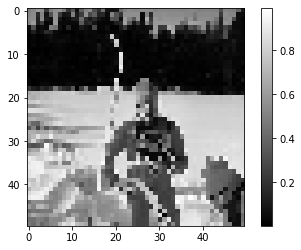

Image size: (50, 50)


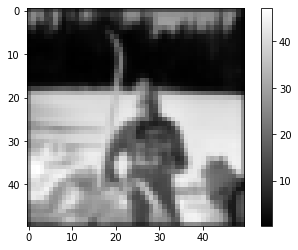

Image size: (50, 50)


In [19]:
visualize(RGB_sum[::5,1::5])

visualize(img_same[::5,1::5])

# visualize(img_valid[::5,1::5])

## Layers in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform **eager execution**. This is initialized as follows: 

In [20]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

TensorFlow version 2.1.0


AttributeError: ignored

TensorFlow allows to map from and to numpy. Also, operations are automatically casted.  

#### Keras layers are wrappers for Tensorflow and can be applied in eager mode using the `tf.keras.layers` package.  

---

**Task 6:** Perform the 1D convolution from task 1 using a convolution layer `tf.keras.layers.Conv1D` and a (trivial) `tf.keras.Sequential` model from Keras.

---

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D

f = np.array([1,-1,-2,0,-1,1,2,-1])
f = f.reshape(1,8,1)
h = np.array([1,2,-2])
h = h.reshape(3,1,1)

model_t6_1 = Sequential()
model_t6_1.add(Conv1D(1,3, strides = 1, padding = 'same',input_shape = (8,1)))
weights = model_t6_1.layers[0].get_weights()
# Set the weights to h
weights[0] = h
model_t6_1.layers[0].set_weights(weights)
output = model_t6_1.predict(f)    
print('same: ',output.reshape(8,))

model_t6_2 = Sequential()
model_t6_2.add(Conv1D(1,3, strides = 1, padding = 'valid',input_shape = (8,1)))
weights = model_t6_2.layers[0].get_weights()
# Set the weights to h
weights[0] = h
model_t6_2.layers[0].set_weights(weights)
output = model_t6_2.predict(f)    
print('Valid: ',output.reshape(6,))

same:  [ 3.9999995e+00  2.9999990e+00 -4.9999981e+00 -5.0637269e-08
 -4.0000005e+00 -2.9999995e+00  6.9999986e+00 -3.2782555e-07]
Valid:  [ 3. -5.  0. -4. -3.  7.]


**Task 7:** Apply the cascaded $33\times33$ filter from task 3 to the image using a `tf.keras.layers.Conv2D` layer. Compare the results from *Scipy* in task 3 and *Tensorflow* in this task.

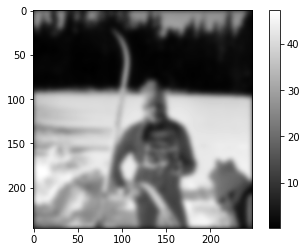

Image size: (246, 248)


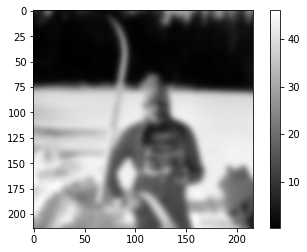

Image size: (214, 216)


In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from scipy import signal

img = imread('MR15^044.JPG')
RGB_sum = np.sum(img,axis = 2)
RGB_sum = RGB_sum/RGB_sum.max()

[row,col] = RGB_sum.shape

RGB_sum = RGB_sum.reshape(1,row ,col, 1)

h = np.array([[1,1],[1,1]])
for i  in range(0,5):
     h = signal.convolve2d(h,h)

h = h/h.max() 

h = h.reshape(33,33,1,1)

model_t7_1 = Sequential()
model_t7_1.add(Conv2D(1,(33,33), strides = 1, padding = 'same',input_shape = (row,col,1)))
weights = model_t7_1.layers[0].get_weights()
weights[0] = h

model_t7_1.layers[0].set_weights(weights)
output_t7_1 = model_t7_1.predict(RGB_sum)    
visualize(output_t7_1.reshape(row,col))

model_t7_2 = Sequential()
model_t7_2.add(Conv2D(1,(33,33), strides = 1, padding = 'valid',input_shape = (row,col,1)))
weights = model_t7_2.layers[0].get_weights()
weights[0] = h

model_t7_2.layers[0].set_weights(weights)
output_t7_2 = model_t7_2.predict(RGB_sum)    
visualize(output_t7_2.reshape(row-33+1,col-33+1))

**Task 8:** Repeat the previous task with stride 5. Compare with the result from task 5.


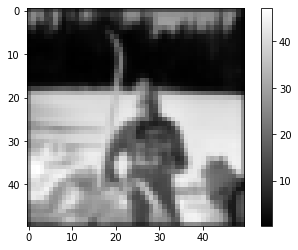

Image size: (50, 50)


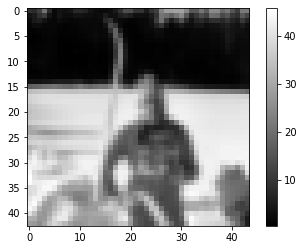

Image size: (43, 44)


In [23]:
model_t8_1 = Sequential()
model_t8_1.add(Conv2D(1,(33,33), strides = 5, padding = 'same',input_shape = (row,col,1)))
weights = model_t8_1.layers[0].get_weights()
weights[0] = h

model_t8_1.layers[0].set_weights(weights)
output_t8_1 = model_t8_1.predict(RGB_sum)    
visualize(output_t8_1.reshape(50,50))

model_t8_2 = Sequential()
model_t8_2.add(Conv2D(1,(33,33), strides = 5, padding = 'valid',input_shape = (row,col,1)))
weights = model_t8_2.layers[0].get_weights()
weights[0] = h

model_t8_2.layers[0].set_weights(weights)
output_t8_2 = model_t8_2.predict(RGB_sum)    
visualize(output_t8_2.reshape(43,44))


**Task 9:** Repeat task 7 with stride of 5 and a $1\times1$ filter. Compare with the result from task 5.

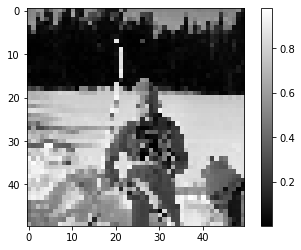

Image size: (50, 50)


In [24]:
w= np.array([[1]])

w = w.reshape(1,1,1,1)

model_t9 = Sequential()
model_t9.add(Conv2D(1,(1,1), strides = 5, padding = 'same',input_shape = (row,col,1)))
weights = model_t9.layers[0].get_weights()
weights[0] = w

model_t9.layers[0].set_weights(weights)
output_t9 = model_t9.predict(RGB_sum)    

visualize(output_t9.reshape(50, 50))

---

**Task 10:** Generate a new $33\times33$ filter that is anti-symmetric in one axis (the one used so far was symmetric), add it as a second channel, and add its transpose to a third channel. Repeat task 7 for the new filters using both *Tensorflow* and *Scipy*. What differences do you observe between the two libraries?

*Hint*: You can generate the anti-symmetric filter by multiplying the symmetric $h$ with a matrix that has constant row elements in the range [-16,16].

---

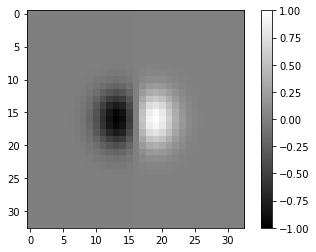

Image size: (33, 33)


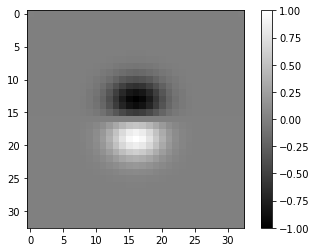

Image size: (33, 33)
With Scipy


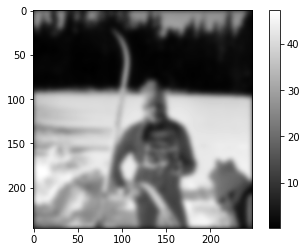

Image size: (246, 248)


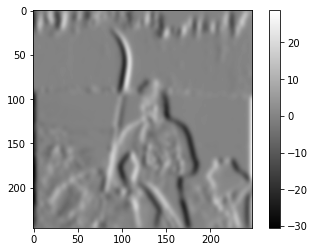

Image size: (246, 248)


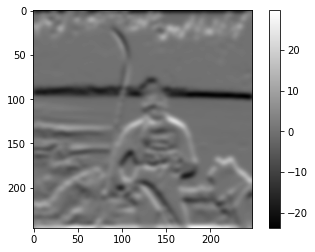

Image size: (246, 248)
With TensorFlow


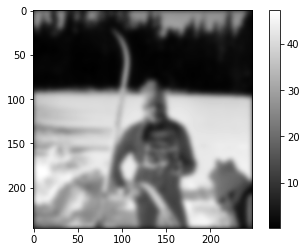

Image size: (246, 248)


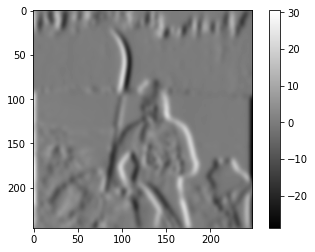

Image size: (246, 248)


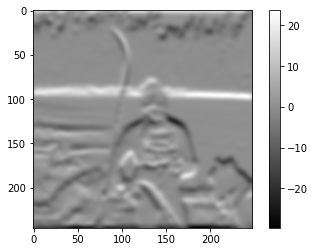

Image size: (246, 248)


In [25]:
h = np.array([[1,1],[1,1]])
for i  in range(0,5):
     h = signal.convolve2d(h,h)
        
h = h/h.max()        

        
img = imread('MR15^044.JPG')

RGB_sum = np.sum(img,axis = 2)
RGB_sum = RGB_sum/RGB_sum.max()
[row,col] = RGB_sum.shape

        
p = np.reshape(np.array(range(-16, 17,1)),(1,33))
p = np.repeat(p,33,axis = 0)
h1 = np.multiply(h,p)
h1 = h1/h1.max()
visualize(h1)
h2 = np.transpose(h1)
visualize(h2)

print('With Scipy')
img1 = signal.convolve2d(RGB_sum,h, mode = 'same')
visualize(img1)

img2 = signal.convolve2d(RGB_sum,h1, mode = 'same')
visualize(img2)

img3 = signal.convolve2d(RGB_sum,h2, mode = 'same')
visualize(img3)


RGB_sum = RGB_sum.reshape(1,row ,col, 1)

h  = h.reshape(33,33,1)
h1 = h1.reshape(33,33,1)
h2 = h2.reshape(33,33,1)


print('With TensorFlow')

model_t10 = Sequential()
model_t10.add(Conv2D(3,(33,33), strides = 1, padding = 'same',input_shape = (row,col,1)))
weights = model_t10.layers[0].get_weights()

weights[0] = np.stack([h,h1,h2],axis =3 )
model_t10.layers[0].set_weights(weights)


output_t10 = model_t10.predict(RGB_sum)  

visualize(output_t10[0,:,:,0])
visualize(output_t10[0,:,:,1])
visualize(output_t10[0,:,:,2])

## Training layers
Now, we want the network to learn the convolution filter given the input and the convolved output.

**Task 11:** Take the input and the convolved output from task 7 and put them in tensors `batch` and `label` respectively. 

*Hint*: Check the documentation of `tf.keras.layers.Conv2D` to get the proper shape for the input and the output tensors.


In [0]:
batch = RGB_sum.astype(np.float32)
label = output_t7_1/output_t7_1.max()
label = label.astype(np.float32)
#print(btch.shape)
#print(labl.shape)

#visualize(batch[0,:,:,0])
#visualize(label[0,:,:,0])

**Task 12:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

---

In [0]:
def loss(model, x, y):
    error = tf.abs(model(x)-y)
    loss =  tf.reduce_mean(error)     
    return loss

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  

**Task 13:** Train the model from task 7 (but without assigning the weights) using the tensors from task 11, the loss from task 12, and `GradientDescentOptimizer()`. 

During training, print the loss every 100 steps and visualize the learned kernel after training.  

*Hint*: add a `kernel_constraint` to be non-negative for the convolution layer.

---

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM). 

---

In [0]:
optimizer = tf.optimizers.SGD(learning_rate=0.0005)


In [32]:
model_t13 = tf.keras.Sequential()
model_t13.add(tf.keras.layers.Conv2D(1,(33,33), padding = 'same',input_shape = (row,col,1), use_bias=False,
                     kernel_constraint=tf.keras.constraints.NonNeg()))

train_steps = 1000

for i in range(0,train_steps):
    with tf.GradientTape() as tape:
        loss_value = loss(model_t13,batch,label)
        
    grads = tape.gradient(loss_value, model_t13.variables)
    optimizer.apply_gradients(zip(grads, model_t13.variables))
    
    if (i%100 == 0):
        print(float(loss_value))

0.8373215198516846
1.659202218055725
0.09516922384500504
0.06624303758144379
0.04205968976020813
0.023237887769937515
0.011195358820259571
0.0049839988350868225
0.026474006474018097
0.028242910280823708


In [0]:
optimizer = tf.optimizers.Adam(learning_rate=0.0005)


In [36]:
model_t13_1 = tf.keras.Sequential()
model_t13_1.add(tf.keras.layers.Conv2D(1,(33,33), padding = 'same',input_shape = (row,col,1), use_bias=False,
                     kernel_constraint=tf.keras.constraints.NonNeg()))

train_steps = 1000

for i in range(0,train_steps):
    with tf.GradientTape() as tape:
        loss_value = loss(model_t13_1,batch,label)
        
    grads = tape.gradient(loss_value, model_t13_1.variables)
    optimizer.apply_gradients(zip(grads, model_t13_1.variables))
    
    if (i%100 == 0):
        print(float(loss_value))

1.0151723623275757
0.08158319443464279
0.013067084364593029
0.008071549236774445
0.007092041429132223
0.006687590386718512
0.006478399038314819
0.006353315431624651
0.0062468405812978745
0.006161271594464779


## Training a whole network

**IMPORTANT**: The reminder of the lab will be executed in *graph* mode. So make sure to restart the kernel from `kernel` menu above.

---

So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. 

If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. However, debugging becomes a bit more difficult which is why we need an additional tool.  

*  Keras models come with a handy member variable `history` for this purpose, which we will use below.  
*  TensorFlow comes by default with `tensorboard` (which we will not use here). To use it, the code needs to be extended with named tags for all entities that are supposed to be observable. A key module is `tf.summary` with functions for various types and the 'collector' `tf.summary.merge_all()`. Tensorboard itself is then launched using `tensorboard --logdir /tmp/...` where the exact filename is specified as argument `tf.summary.FileWriter()`. In order to see graphs of the observed entities, a browser needs to be directed to `localhost:6006`.


In [0]:
import tensorflow as tf
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

**Task 14:** We will train on CIFAR10, which is supported by Keras. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

In [0]:
# Download the Cifar10 dataset
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
from matplotlib import pyplot as plt

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

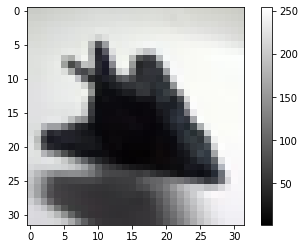

Image size: (32, 32, 3)


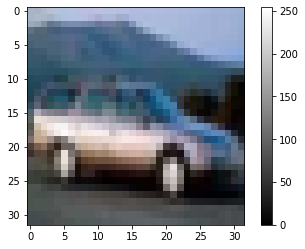

Image size: (32, 32, 3)


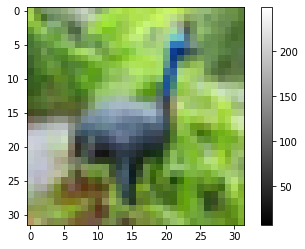

Image size: (32, 32, 3)


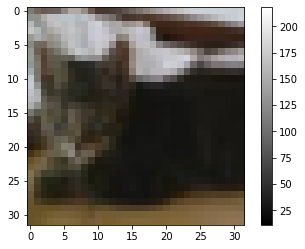

Image size: (32, 32, 3)


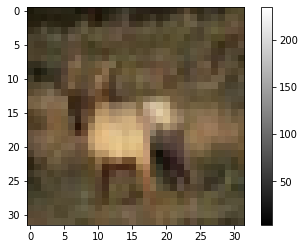

Image size: (32, 32, 3)


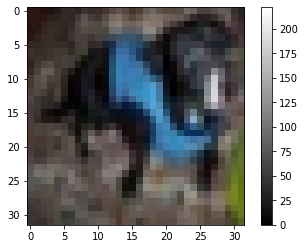

Image size: (32, 32, 3)


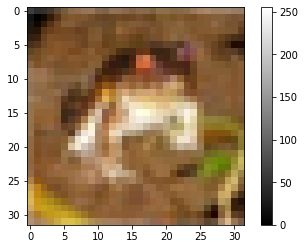

Image size: (32, 32, 3)


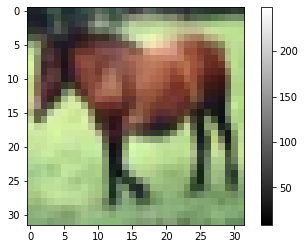

Image size: (32, 32, 3)


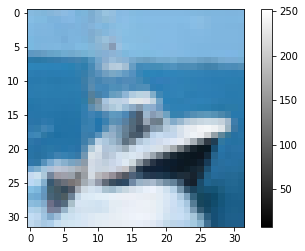

Image size: (32, 32, 3)


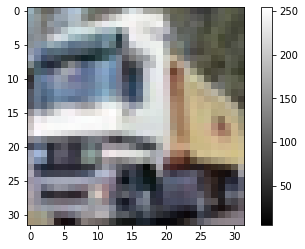

Image size: (32, 32, 3)


In [41]:
# Show a sample for each class. Find the index for unique elements
uni,idx = np.unique(y_train,return_index=True)
for i in idx:
    visualize(x_train[i])

uni_len = len(uni) 

In [0]:
import keras
# Normalize the Images
x_train = x_train/x_train.max()
x_test = x_test/x_test.max()

# Convert the Labels to One-hot Coding
y_train_hot = keras.utils.to_categorical(y_train, num_classes=uni_len)
y_test_hot  = keras.utils.to_categorical(y_test, num_classes=uni_len)

**Task 15:** Build the depicted LeNet5-inspired model using Keras standard components.
![title](model.png)

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, MaxPool2D, Activation, BatchNormalization, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2,l1

In [55]:
model_t15 = Sequential()

model_t15.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(32,32,3)))
model_t15.add(BatchNormalization())
model_t15.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(32,32,32)))
model_t15.add(BatchNormalization())
model_t15.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t15.add(Dropout(0.2))
model_t15.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(16,16,32)))
model_t15.add(BatchNormalization())
model_t15.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(16,16,64)))
model_t15.add(BatchNormalization())
model_t15.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t15.add(Dropout(0.3))
model_t15.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(8,8,64)))
model_t15.add(BatchNormalization())
model_t15.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(8,8,128)))
model_t15.add(BatchNormalization())
model_t15.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t15.add(Dropout(0.4))
model_t15.add(Flatten())
model_t15.add(Dense(uni_len,activation='softmax'))

initial_lr = 5e-4

adam = Adam(lr=5e-4)
model_t15.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

print(model_t15.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

### Baseline
We will now train a baseline network. For displaying the performance we define a helper function:

In [0]:
def plot_model_history(model):
    plt.figure(0)
    plt.plot(model.history['accuracy'],'r', lw=3)
    plt.plot(model.history['val_accuracy'],'b', lw=3)
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['Training','Validation'])
    plt.grid(True)

**Task 16:** Train the *baseline* model for 50 epochs and a suitable batch size and display the result.

---

In [57]:
model_15=model_t15.fit(x_train,y_train_hot,epochs=50,batch_size=500,validation_data=(x_test,y_test_hot))


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 164us/step - loss: 2.1449 - accuracy: 0.3633 - val_loss: 3.2770 - val_accuracy: 0.1717
Epoch 2/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5205 - accuracy: 0.4951 - val_loss: 2.9004 - val_accuracy: 0.2310
Epoch 3/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.2556 - accuracy: 0.5743 - val_loss: 2.3436 - val_accuracy: 0.3206
Epoch 4/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.1070 - accuracy: 0.6225 - val_loss: 1.6036 - val_accuracy: 0.5028
Epoch 5/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0102 - accuracy: 0.6540 - val_loss: 1.0118 - val_accuracy: 0.6468
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.9295 - accuracy: 0.6812 - val_loss: 0.9255 - val_accuracy: 0.6868
Epoch 7/50
50000/50000 [==============================] - 7s 1

In [64]:
#for key in model_15.history.keys():
#    print(key)

val_loss
val_accuracy
loss
accuracy


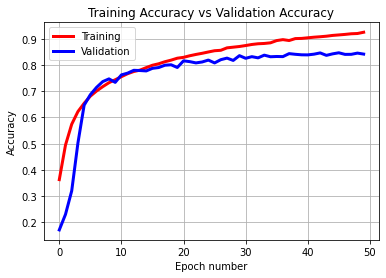

In [68]:
plot_model_history(model_15)

### Baseline + Decaying Learning Rate
In most papers, the learning rate is successively reduced in order to boost the final performance, e.g. divided by two after 30 and 40 epochs.  

**Task 17:** Define a suitable callback function and train the previous model with decaying learning rate. Plot the result and compare it to the baseline.

In [0]:
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def lr_decay_schedule(epoch,lr):
    lrate1 = lr
    if epoch == 30 :
        lrate1 = lrate1/2
    if epoch == 40 :
        lrate1 = lrate1/2
    
    return lrate1

lrate = LearningRateScheduler(lr_decay_schedule)
callbacks_list = [lrate]

In [62]:
model_t17 = Sequential()

model_t17.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(32,32,3)))
model_t17.add(BatchNormalization())
model_t17.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(32,32,32)))
model_t17.add(BatchNormalization())
model_t17.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t17.add(Dropout(0.2))
model_t17.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(16,16,32)))
model_t17.add(BatchNormalization())
model_t17.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(16,16,64)))
model_t17.add(BatchNormalization())
model_t17.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t17.add(Dropout(0.3))
model_t17.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(8,8,64)))
model_t17.add(BatchNormalization())
model_t17.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', input_shape=(8,8,128)))
model_t17.add(BatchNormalization())
model_t17.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t17.add(Dropout(0.4))
model_t17.add(Flatten())
model_t17.add(Dense(uni_len,activation='softmax'))

print(model_t17.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)       

In [63]:
adam = Adam(lr=5e-4)
model_t17.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


model_17=model_t17.fit(x_train,y_train_hot,epochs=50,batch_size=500,callbacks=callbacks_list, validation_data=(x_test,y_test_hot))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 166us/step - loss: 2.1142 - accuracy: 0.3668 - val_loss: 3.1000 - val_accuracy: 0.2022
Epoch 2/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.5231 - accuracy: 0.4942 - val_loss: 3.0801 - val_accuracy: 0.1911
Epoch 3/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.2721 - accuracy: 0.5716 - val_loss: 2.5308 - val_accuracy: 0.3063
Epoch 4/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.1260 - accuracy: 0.6165 - val_loss: 1.7292 - val_accuracy: 0.4277
Epoch 5/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0220 - accuracy: 0.6508 - val_loss: 1.0108 - val_accuracy: 0.6494
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 0.9319 - accuracy: 0.6754 - val_loss: 0.8398 - val_accuracy: 0.7077
Epoch 7/50
50000/50000 [==============================] - 7s 1

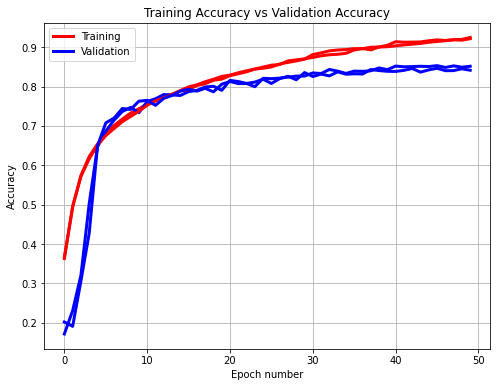

In [69]:
plot_model_history(model_15)
plot_model_history(model_17)

### Weight regularization + Decaying Learning rate

**Task 18:** Add weight regularization and train the model from the previous task with varying decay rate.

In [0]:
model_t18 = Sequential()
k_l2 = 0.001
b_l2 = 0.000
k_reg = l2(k_l2)
b_reg = l2(b_l2)


model_t18.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(32,32,3)))
model_t18.add(BatchNormalization())
model_t18.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(32,32,32)))
model_t18.add(BatchNormalization())
model_t18.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t18.add(Dropout(0.2))
model_t18.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(16,16,32)))
model_t18.add(BatchNormalization())
model_t18.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(16,16,64)))
model_t18.add(BatchNormalization())
model_t18.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t18.add(Dropout(0.3))
model_t18.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(8,8,64)))
model_t18.add(BatchNormalization())
model_t18.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(8,8,128)))
model_t18.add(BatchNormalization())
model_t18.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t18.add(Dropout(0.4))
model_t18.add(Flatten())
model_t18.add(Dense(uni_len,activation='softmax', kernel_regularizer=k_reg,bias_regularizer=b_reg))

ini_lr = 5e-4
        
adam = Adam(lr=ini_lr)

In [71]:
adam = Adam(lr=5e-4)
model_t18.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


model_18=model_t18.fit(x_train,y_train_hot,epochs=50,batch_size=500,callbacks=callbacks_list, validation_data=(x_test,y_test_hot))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.5352 - accuracy: 0.3572 - val_loss: 3.3796 - val_accuracy: 0.1409
Epoch 2/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.9050 - accuracy: 0.4905 - val_loss: 3.7117 - val_accuracy: 0.1980
Epoch 3/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6307 - accuracy: 0.5670 - val_loss: 2.9254 - val_accuracy: 0.2632
Epoch 4/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.4595 - accuracy: 0.6177 - val_loss: 2.0518 - val_accuracy: 0.4315
Epoch 5/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.3357 - accuracy: 0.6540 - val_loss: 1.3734 - val_accuracy: 0.6382
Epoch 6/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.2458 - accuracy: 0.6783 - val_loss: 1.2102 - val_accuracy: 0.6879
Epoch 7/50
50000/50000 [==============================] - 7s 1

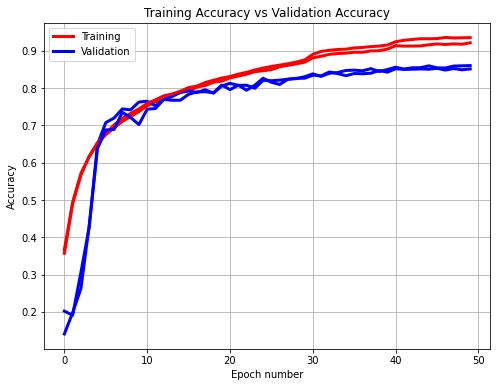

In [72]:
plot_model_history(model_17)
plot_model_history(model_18)

### Weight Regularization + Data Augmentation + Decaying learning rate
**Task 19:** Use `ImageDataGenerator`to perform additional augmentation with rotation. Adjust the number of epochs and the learning rate schedule if needed. What do you observe?

In [0]:
model_t19 = Sequential()
k_l2 = 0.001
b_l2 = 0.001
k_reg = l2(k_l2)
b_reg = l2(b_l2)


model_t19.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(32,32,3)))
model_t19.add(BatchNormalization())
model_t19.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(32,32,32)))
model_t19.add(BatchNormalization())
model_t19.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t19.add(Dropout(0.2))
model_t19.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(16,16,32)))
model_t19.add(BatchNormalization())
model_t19.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(16,16,64)))
model_t19.add(BatchNormalization())
model_t19.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t19.add(Dropout(0.3))
model_t19.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(8,8,64)))
model_t19.add(BatchNormalization())
model_t19.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='elu', kernel_regularizer=k_reg,bias_regularizer=b_reg, input_shape=(8,8,128)))
model_t19.add(BatchNormalization())
model_t19.add(MaxPool2D(pool_size=(2,2), strides=None, padding='same'))
model_t19.add(Dropout(0.4))
model_t19.add(Flatten())
model_t19.add(Dense(uni_len,activation='softmax', kernel_regularizer=k_reg,bias_regularizer=b_reg))

ini_lr = 5e-4
        
adam = Adam(lr=ini_lr)
model_t19.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])    

In [0]:
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def lr_decay_schedule(epoch,lr):
    lrate1 = lr
    if epoch == 10:
        lrate1 = lrate1/2
    if epoch == 20:
        lrate1 = lrate1/2
    if epoch == 30:
        lrate1 = lrate1/2
    if epoch == 40:
        lrate1 = lrate1/2
    return lrate1

lrate = LearningRateScheduler(lr_decay_schedule)
callbacks_list = [lrate]

In [75]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,# randomly rotate images in the range (degrees, 0 to 180)
       # horizontal_flip=True,  # randomly flip images
        )

#datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:
model_19=model_t19.fit_generator(datagen.flow(x_train, y_train_hot, batch_size=128),
                    steps_per_epoch=len(x_train) / 128, epochs=50, callbacks = callbacks_list, validation_data=(x_test,y_test_hot))

Epoch 1/50
391/390 [==============================] - 22s 57ms/step - loss: 2.3060 - accuracy: 0.3982 - val_loss: 2.4480 - val_accuracy: 0.3267
Epoch 2/50
391/390 [==============================] - 21s 52ms/step - loss: 1.7167 - accuracy: 0.5319 - val_loss: 1.5215 - val_accuracy: 0.5936
Epoch 3/50
391/390 [==============================] - 20s 52ms/step - loss: 1.4458 - accuracy: 0.6140 - val_loss: 1.4388 - val_accuracy: 0.6303
Epoch 4/50
391/390 [==============================] - 20s 52ms/step - loss: 1.2848 - accuracy: 0.6580 - val_loss: 1.1514 - val_accuracy: 0.7040
Epoch 5/50
391/390 [==============================] - 21s 53ms/step - loss: 1.1765 - accuracy: 0.6915 - val_loss: 1.0729 - val_accuracy: 0.7256
Epoch 6/50
391/390 [==============================] - 21s 53ms/step - loss: 1.0921 - accuracy: 0.7125 - val_loss: 1.0315 - val_accuracy: 0.7383
Epoch 7/50
391/390 [==============================] - 21s 53ms/step - loss: 1.0247 - accuracy: 0.7337 - val_loss: 1.0250 - val_accuracy:

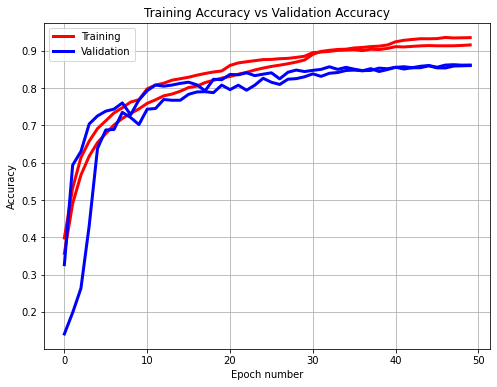

In [76]:
plot_model_history(model_18)
plot_model_history(model_19)

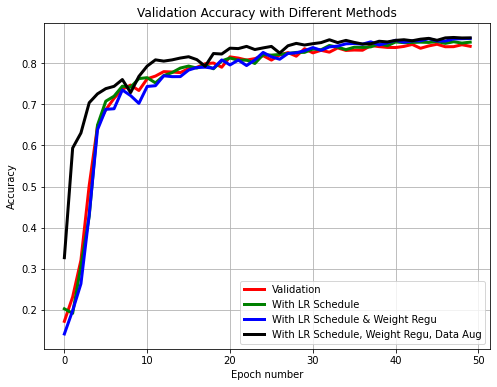

In [78]:
plt.figure()
plt.plot(model_15.history['val_accuracy'],'r', lw=3)
plt.plot(model_17.history['val_accuracy'],'g', lw=3)
plt.plot(model_18.history['val_accuracy'],'b', lw=3)
plt.plot(model_19.history['val_accuracy'],'k', lw=3)
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy with Different Methods")
plt.legend(['Validation','With LR Schedule','With LR Schedule & Weight Regu','With LR Schedule, Weight Regu, Data Aug'])
plt.grid(True)